In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 2. Draw AQI (PM2.5) Image 

### 2.1 Prepare x,y,z Data 

In [4]:
df_all = pd.read_csv(r'D:\Tommy\+WeatherData\china_aqi_map\aqi_all.csv')
print(df_all)

       s_id loc_name  city       lon       lat  value
0     1001A     万寿西宫    北京  116.3621  39.87840   47.0
1     1002A  定陵(对照点)    北京  116.2202  40.29150   12.0
2     1003A       东四    北京  116.4174  39.92890   65.0
3     1004A       天坛    北京  116.4072  39.88630   45.0
4     1005A      农展馆    北京  116.4620  39.93650   44.0
...     ...      ...   ...       ...       ...    ...
1697  3734A     理想之城    东营  118.3500  37.26000   51.0
1698  3860A   皇山花园小区    临沂  118.3920  35.03000   32.0
1699  3861A  寒亭区实验一小    潍坊  119.2041  36.76990   39.0
1700  3866A      三高中    营口  122.2469  40.66302   22.0
1701  3867A  平安区公安北苑  海东地区  102.0738  36.50560   39.0

[1702 rows x 6 columns]


In [16]:
x = df_all['lon'].values
y = df_all['lat'].values
z = df_all['value'].values

In [17]:
print(x)
print(y)
print(z)

[116.3621 116.2202 116.4174 ... 119.2041 122.2469 102.0738]
[39.8784  40.2915  39.9289  ... 36.7699  40.66302 36.5056 ]
[47. 12. 65. ... 39. 22. 39.]


### 2.2 Generate the grid to interpolate

In [19]:
# size of the grid to interpolate
nx, ny = 650, 400 
xmin = 71
xmax = 136
ymin = 15
ymax = 55


# generate two arrays of evenly space data between ends of previous arrays
xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymin, ymax, ny)
print(xi)
print(yi)

[ 71.          71.10015408  71.20030817  71.30046225  71.40061633
  71.50077042  71.6009245   71.70107858  71.80123267  71.90138675
  72.00154083  72.10169492  72.201849    72.30200308  72.40215716
  72.50231125  72.60246533  72.70261941  72.8027735   72.90292758
  73.00308166  73.10323575  73.20338983  73.30354391  73.403698
  73.50385208  73.60400616  73.70416025  73.80431433  73.90446841
  74.0046225   74.10477658  74.20493066  74.30508475  74.40523883
  74.50539291  74.605547    74.70570108  74.80585516  74.90600924
  75.00616333  75.10631741  75.20647149  75.30662558  75.40677966
  75.50693374  75.60708783  75.70724191  75.80739599  75.90755008
  76.00770416  76.10785824  76.20801233  76.30816641  76.40832049
  76.50847458  76.60862866  76.70878274  76.80893683  76.90909091
  77.00924499  77.10939908  77.20955316  77.30970724  77.40986133
  77.51001541  77.61016949  77.71032357  77.81047766  77.91063174
  78.01078582  78.11093991  78.21109399  78.31124807  78.41140216
  78.5115562

In [20]:
# generate grid 
xi, yi = np.meshgrid(xi, yi)

# colapse grid into 1D
xi, yi = xi.flatten(), yi.flatten()
print(xi)
print(yi)

[ 71.          71.10015408  71.20030817 ... 135.79969183 135.89984592
 136.        ]
[15. 15. 15. ... 55. 55. 55.]


### 2.3 Functions for simple IDW

In [27]:
from matplotlib.colors import LinearSegmentedColormap


In [21]:
def distance_matrix(x0, y0, x1, y1):
    """ Make a distance matrix between pairwise observations.
    Note: from <http://stackoverflow.com/questions/1871536> 
    """
    
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])
    
    # calculate hypotenuse
    return np.hypot(d0, d1)

In [22]:
def simple_idw(x, y, z, xi, yi, power=1):
    """ Simple inverse distance weighted (IDW) interpolation 
    Weights are proportional to the inverse of the distance, so as the distance
    increases, the weights decrease rapidly.
    The rate at which the weights decrease is dependent on the value of power.
    As power increases, the weights for distant points decrease rapidly.
    """
    
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0/(dist+1e-12)**power

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    return np.dot(weights.T, z)

In [ ]:
# "Viridis-like" colormap with white background
    white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
        (0, '#009966'),
        (0.143, '#ffde33'),
        (0.286, '#ff9933'),
        (0.429, '#cc0033'),
        (0.7715, '#660099'),
        (1, '#7e0023'),
    ], N=500)

In [84]:
def plot(x,y,z,grid):
    # "Viridis-like" colormap with white background
    white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
        (0,'#55dbf9'),
        (0.05, '#009966'),
        (0.1, '#ffde33'),
        (0.2, '#ff9933'),
        (0.3, '#cc0033'),
        (0.4, '#660099'),
        (1, '#7e0023')
    ], N=128)

    """ Plot the input points and the result """
    plt.figure(figsize=(15,10))
    plt.imshow(grid, extent=(xmin, xmax, ymax, ymin), cmap=white_viridis, interpolation='gaussian')
    #plt.scatter(x,y,c=z, cmap='rainbow', edgecolors='black')
    ax = plt.gca()
    ax.invert_yaxis()
    plt.colorbar()

### 2.4 Run the Interpolation

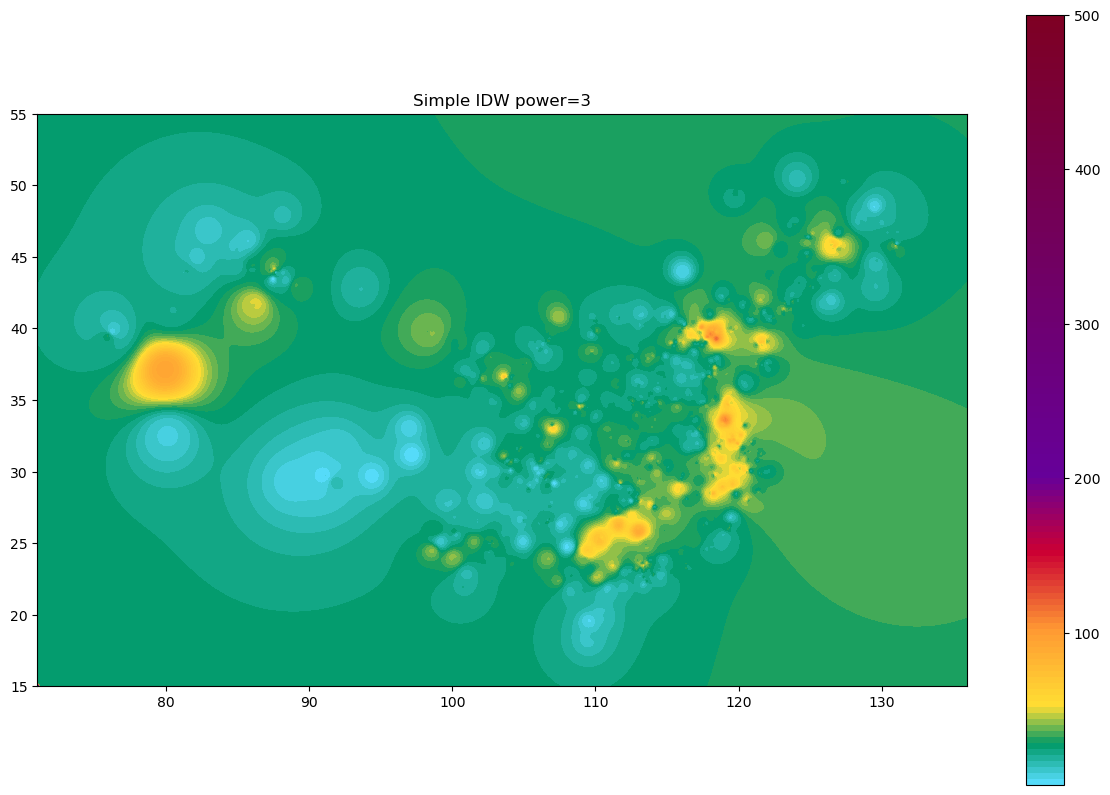

In [85]:
 # Calculate IDW
grid1 = simple_idw(x,y,z,xi,yi, power=3)
grid1 = grid1.reshape((ny, nx))
grid1[0][0]=500
plot(x,y,z,grid1)
plt.title('Simple IDW power=3')
plt.show()

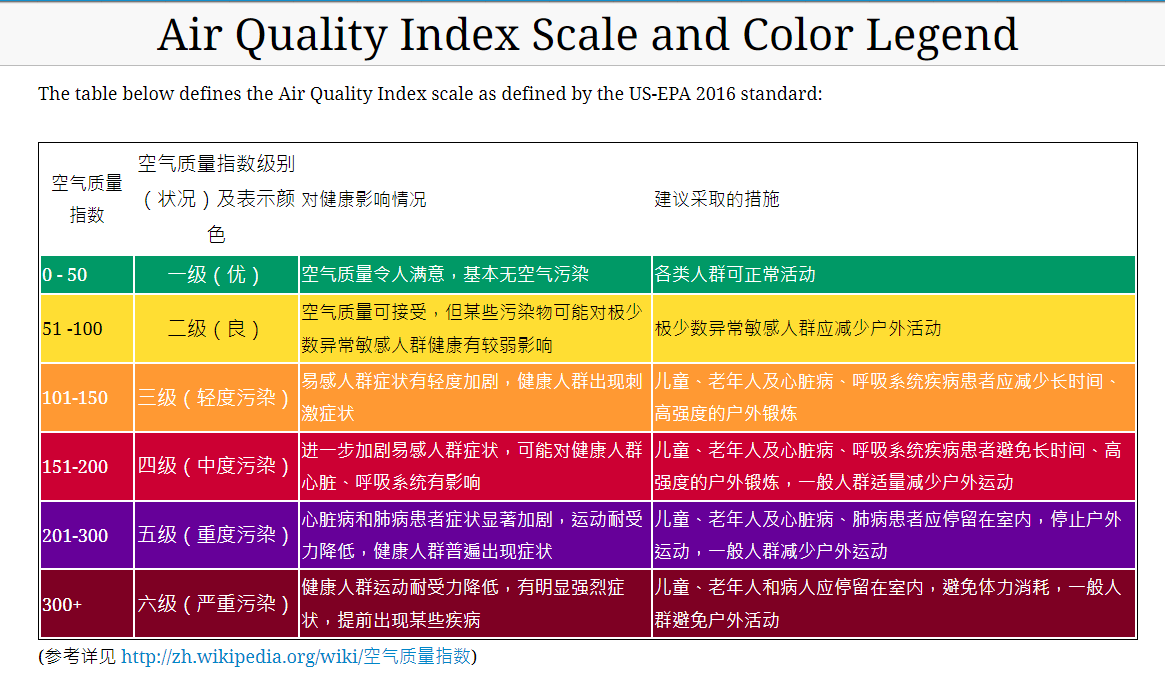

### 3.Map in mercator

### 3.1 Plot Mercator Map

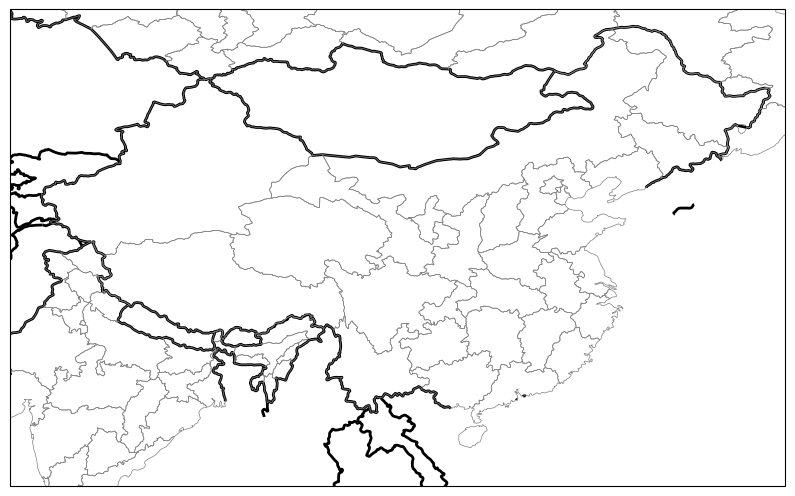

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the Google tile radar image
radar_tile = plt.imread(r'D:\Tommy\+WeatherData\accu_aqi_tiles\plumb\test\20230503-10-55-38.png')

# Define the map projection
#proj = ccrs.Mercator()
proj = ccrs.PlateCarree()
# Plot the radar tile image
fig = plt.figure(figsize=(10, 10.5))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Plot the country borders

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
#cfeature.BORDERS
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=2, edgecolor='black')
#ax.add_feature(cfeature.COASTLINE,linestyle='-', edgecolor='black', linewidth=1)
ax.add_feature(cfeature.STATES,linestyle='-', edgecolor='gray', linewidth=0.5)
#ax.add_feature(cfeature.STATES, linestyle='-', linewidth=1, edgecolor='gray')

# Plot the radar tile image on the map 
#extent is [xmin,xmax,ymin,ymax]
#ax.imshow(radar_tile, origin='upper', extent=[13775787, 14401959, 4383205, 5009377],transform=proj, alpha=0.5)
#tile 54,39
#ax.imshow(radar_tile, origin='upper', extent=[123.75, 129.374999, 36.597889,  40.979897],transform=proj, alpha=0.5)
#tile 55,38
#ax.imshow(radar_tile, origin='upper', extent=[129.374999, 134.999998, 31.952164,  36.597889],transform=proj, alpha=0.5)
# Set the x and y axis limits
ax.set_xlim(xmin,xmax) #[xmin,xmax]
ax.set_ylim( ymin,ymax) #[ymin, ymax]

# Save the final image
plt.savefig(r'D:\Tommy\+WeatherData\china_aqi_map\aqiimage_with_borders.png', dpi=300, bbox_inches='tight')

### 3.2 Convert x,y from lat/lon to real x,y

In [96]:
df_all = pd.read_csv(r'D:\Tommy\+WeatherData\china_aqi_map\aqi_all.csv')
x = df_all['lon'].values
y = df_all['lat'].values
z = df_all['value'].values
print(x)

[116.3621 116.2202 116.4174 ... 119.2041 122.2469 102.0738]


In [97]:
def geographic_to_web_mercator(x_lon, y_lat):
    if abs(x_lon) <= 180 and abs(y_lat) < 90:
        num = x_lon * 0.017453292519943295
        x = 6378137.0 * num
        a = y_lat * 0.017453292519943295
        x_mercator = x
        y_mercator = 3189068.5 * math.log((1.0 + math.sin(a)) / (1.0 - math.sin(a)))
        return x_mercator, y_mercator
    else:
        print('Invalid coordinate values for conversion')      

In [99]:
def GPStoXY(self, lat, lon, ref_lat, ref_lon):
        # input GPS and Reference GPS in degrees
        # output XY in meters (m) X:North Y:East
        lat_rad = math.radians(lat)
        lon_rad = math.radians(lon)
        ref_lat_rad = math.radians(ref_lat)
        ref_lon_rad = math.radians(ref_lon)

        sin_lat = math.sin(lat_rad)
        cos_lat = math.cos(lat_rad)
        ref_sin_lat = math.sin(ref_lat_rad)
        ref_cos_lat = math.cos(ref_lat_rad)

        cos_d_lon = math.cos(lon_rad - ref_lon_rad)

        arg = np.clip(ref_sin_lat * sin_lat + ref_cos_lat * cos_lat * cos_d_lon, -1.0, 1.0)
        c = math.acos(arg)

        k = 1.0
        if abs(c) > 0:
            k = (c / math.sin(c))

        x = float(k * (ref_cos_lat * sin_lat - ref_sin_lat * cos_lat * cos_d_lon) * self.CONSTANTS_RADIUS_OF_EARTH)
        y = float(k * cos_lat * math.sin(lon_rad - ref_lon_rad) * self.CONSTANTS_RADIUS_OF_EARTH)

        return x, y


In [111]:
import os 
from pyproj import CRS
from pyproj import Transformer
#from converter import wgs84_to_gcj02    #参见注意事项

input_file = r'D:\Tommy\+WeatherData\china_aqi_map\aqi_all_for_mercator.csv'
output_file = r'D:\Tommy\+WeatherData\china_aqi_map\aqi_all_latlon_xy.csv'

#当地坐标系转WGS84
#from_crs = CRS.from_wkt('PROJCS["local",GEOGCS["GCS_Xian_1980",DATUM["D_Xian_1980",SPHEROID["Xian_1980",6378140.0,298.257]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",135005.0014],PARAMETER["False_Northing",-1999781.9795],PARAMETER["Central_Meridian",109.75],PARAMETER["Scale_Factor",1.0],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]')
#to_crs = CRS.from_epsg(4326)
#transformer = Transformer.from_crs(from_crs, to_crs, always_xy=True)

#WGS84转Web Mercator
from_crs_2 = CRS.from_epsg(4326)
to_crs_2 = CRS.from_epsg(3857)
transformer_2 = Transformer.from_crs(from_crs_2, to_crs_2, always_xy=True)

with open(output_file, "w") as fo:    
    str_head = 'sid,lon,lat,x,y,\n'
    fo.write(str_head)
    with open(input_file, "r") as fi:
          while True:
                line = fi.readline()     # 逐行读取
                if not line:
                    break
                else:
                   array = line.split(",")    # x,y 逗号分隔
                   #x1,y1 = transformer.transform(array[1], array[2])   # 当地坐标系转WGS84
                   #x2,y2 = wgs84_to_gcj02(x1, y1)                      # gcj02 坐标偏移
                   x3,y3 = transformer_2.transform(array[1], array[2])             # WGS84转Web Mercator
                   fo.write(",".join([array[0],array[1],array[2].strip(),"{:.6f}".format(x3),"{:.6f}".format(y3)])+'\n')     # 输出到新文件

print('All Done!')

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 190: character maps to <undefined>

#### Draw and clip Image
https://www.cxyzjd.com/article/weixin_32751907/112244248